# Create a density climatology data database

Fit the following function to the climatological buoyancy frequency data:

$$
N^2 = \cdots
$$



In [1]:
from iwatlas import sshdriver
from iwatlas import harmonics

import xarray as xr
import pandas as pd
import numpy as np
from datetime import datetime

from scipy.optimize import least_squares

import matplotlib.pyplot as plt

# Load the climatology object containing monthly-averaged $\rho$


In [2]:
basedir = '/home/suntans/cloudstor/Data/IWAtlas'
sshfile = '{}/NWS_2km_GLORYS_hex_2013_2014_SSHBC_Harmonics.nc'.format(basedir)
ampfile = '{}/NWS_2km_GLORYS_hex_2013_2014_Amplitude_Atlas.nc'.format(basedir)
climfile = '{}/NWS_2km_GLORYS_hex_2013_2014_Climatology.nc'.format(basedir)



amp = sshdriver.load_ssh_clim(ampfile)
amp

<xarray.Dataset>
Dimensions:   (Nc: 225368, Nk: 80, Nkw: 81, Nmode: 4, Np: 454016, Ntide: 5, numsides: 8, time: 23)
Coordinates:
    xv        (Nc) float64 ...
    yv        (Nc) float64 ...
    Nk        (Nc) int32 ...
  * time      (time) datetime64[ns] 2013-07-16 2013-07-31 ... 2014-06-11
    z_w       (Nkw) float64 ...
Dimensions without coordinates: Nc, Nkw, Nmode, Np, Ntide, numsides
Data variables:
    cells     (Nc, numsides) int32 3058 3061 3060 2801 ... 316184 316187 -1 -1
    xp        (Np) float64 1.394e+07 1.271e+07 1.517e+07 ... 1.303e+07 1.303e+07
    yp        (Np) float64 -1.619e+06 -2.553e+06 ... -2.056e+06 -2.055e+06
    nfaces    (Nc) int32 ...
    dv        (Nc) float64 ...
    omega     (Ntide) float64 ...
    modes     (Nmode) float64 ...
    dz        (Nk) float64 ...
    z_r       (Nk) float64 ...
    cn        (time, Nmode, Nc) float64 ...
    alpha_n   (time, Nmode, Nc) float64 ...
    N2        (time, Nkw, Nc) float64 ...
    amp_b_re  (time, Ntide, Nmode, N

# Density fitting routines ripped from: https://github.com/mrayson/iwaves/blob/master/iwaves/utils/density.py

In [1]:
def rho_err(coeffs, rho, z, density_func):
    """
    Returns the difference between the estimated and actual data
    """
    soln = density_func(z, coeffs)

    return rho - soln

def fit_rho_lsq(rho, z, density_func, bounds, initguess):
    """
    Fits an analytical density profile to data
    Uses a robust linear regression
    Inputs:
    ---
        rho: vector of density [Nz]
        z : depth [Nz] w/ negative values i.e. 0 at surface, positive: up
        density_func, bounds, initguess: 
    Returns:
    ---
        rhofit: best fit function at z locations
        f0: tuple with analytical parameters
        err: L2-norm of the error vector
    """

    status = 0

    rho0 = rho.min()

    #rhotry = rho

    # Use "least_squares" at it allows bounds on fitted parameters to be input
    rhotry = rho # - rho0
    H = np.abs(z).max()   

    soln =\
        least_squares(rho_err, initguess, args=(rhotry, z, density_func), \
        bounds=bounds,\
        xtol=1e-10,
        ftol=1e-10,
        loss='cauchy', f_scale=0.1, # Robust
        verbose=0,
        )
    f0 = soln['x']

    rhofit = density_func(z, f0)
    
    err = np.linalg.norm(rhofit - rhotry)

    return rhofit, f0, err

In [2]:
def double_gaussian_N2(z, beta):
    return beta[0] + beta[1] * (np.exp(- ((z+beta[2])/beta[3])**2 )  +\
              np.exp(-((z+beta[4])/beta[5])**2 ) )

def sech(z):
    return 1. / np.cosh(z)

def sech2(z):
    return sech(z)*sech(z)

def double_sech2_N2(z, beta):
    return beta[0] + beta[1] * (sech2((z+beta[2])/beta[3])   +\
              sech2((z+beta[4])/beta[5]) )

In [3]:
z_w = amp._ds.z_w.values
dv = amp._ds['dv'].values
ii = np.argwhere( (dv>2500) & (dv<2550))[-1,0]
tstep = 12

nk = amp._ds.Nk.values[ii]-1
N2 = amp._ds['N2'].values[tstep,0:nk,ii]

initguess = [1e-5,  1e-4, 4, 2, 4.5, 2]
bounds = [ (1e-6, 1e-5, 1, 0.1, 1.4, 0.1), (1e-1, 1e-1, 6, 6, 6, 6)]
N2fit, f0, err = fit_rho_lsq(N2[1:], -np.log(z_w[1:nk]), double_sech2_N2, bounds, initguess)
# N2fit, f0, err = fit_rho_lsq(N2[1:], -np.log(z_w[1:nk]), double_gaussian_N2, bounds, initguess)


plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(np.log(z_w[1:nk]), N2[1:],'.')
plt.plot(np.log(z_w[1:nk]), N2fit,'--')

plt.subplot(122)
plt.plot(z_w[1:nk], N2[1:],'.')
plt.plot(z_w[1:nk], N2fit,'--')
f0, err

NameError: name 'amp' is not defined

In [6]:
amp._ds['N2'].nbytes*1e-9

3.3588846720000003

In [7]:
z_w = amp._ds.z_w.values
Nk = amp._ds.Nk.values
N2all = amp._ds['N2'].values[:]


In [8]:
from tqdm import tqdm

In [9]:
# Initialise the output variables
nt, nz, Nc = amp._ds['N2'].shape
nparams = 6

N2_params = np.zeros((nt,nparams,Nc))
N2_err = np.zeros((nt, Nc))

for ii in tqdm(range(Nc)):
    initguess = [1e-5,  1e-4, 4, 2, 4.5, 2]
    # Skip shallow water
    if dv[ii]<100:
        continue
        
    for tt in range(nt):
        bounds = [ (1e-6, 1e-5, 1, 0.1, 1.4, 0.1), (1e-1, 1e-1, 6, 6, 6, 6)]
        nk = Nk[ii] - 1
        N2 = N2all[tt,1:nk,ii]
        N2fit, f0, err = fit_rho_lsq(N2, -np.log(z_w[1:nk]), double_gaussian_N2, bounds, initguess)
        
        # Use the last time-step as
        initguess = f0
        
        N2_params[tt,:,ii] = f0
        N2_err[tt,ii] = err

100%|██████████| 225368/225368 [6:23:01<00:00,  9.81it/s]


In [49]:
from soda.utils.harmonic_analysis import harmonic_fit_array
twopi = 2*np.pi
tdaysec = 86400.
def harmonic_pred(aa, Aa, Ba, omega, tdays):
    nomega = len(omega)
    nt = tdays.shape[0]
    amp = np.ones_like(tdays) * aa
    for ii in range(nomega):
        amp += Aa[ii,...]*np.cos(omega[ii]*tdays) + Ba[ii,...]*np.sin(omega[ii]*tdays)
    
    return amp

def seasonal_harmonic_fit(X, t, na, omega_A=twopi/(365*tdaysec)):
    frq_all =[n*omega_A for n in range(1,na+1)]

    Y = harmonic_fit_array(X, t, frq_all, axis=0)
    aa = Y[0]
    Aa = Y[1::2]
    Ba = Y[2::2]
    
    return aa, Aa, Ba, frq_all

In [50]:
# Test a harmonic fit
N2ii = N2_params[...]
tsec = (amp._ds.time.values - np.datetime64('2000-01-01 00:00:00')).astype(float)*1e-9

na = 4
aa, Aa, Ba, frq_all = seasonal_harmonic_fit(N2ii, tsec, na)


    

N2ii.shape, Aa.shape

((23, 6, 225368), (4, 6, 225368))

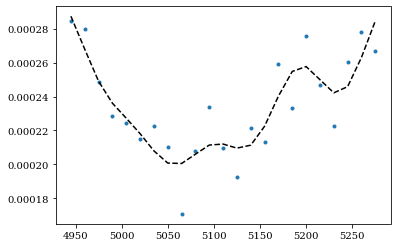

In [53]:
ii= 1000
N2test = N2ii[:,:,ii]

N2_params_fit = np.zeros_like(N2test)
for nn in range(nparams):
    N2_params_fit[:,nn] = harmonic_pred(aa[nn,ii], Aa[:,nn,ii], Ba[:,nn,ii], frq_all, tsec)
nn = 1
plt.figure()
plt.plot(tsec/tdaysec, N2test[:,nn],'.')
plt.plot(tsec/tdaysec, N2_params_fit[:,nn],'k--')

In [54]:
N2_params.shape

(23, 6, 225368)

In [61]:
# Create an output dataset like the input amplitude data set
new_ds = amp._ds.copy()

# Drop a few variables
new_ds = new_ds.drop(labels=['amp_b_re','amp_b_im','alpha_n','cn','omega','N2'])
new_ds

<xarray.Dataset>
Dimensions:  (Nc: 225368, Nk: 80, Nkw: 81, Nmode: 4, Np: 454016, numsides: 8, time: 23)
Coordinates:
    xv       (Nc) float64 ...
    yv       (Nc) float64 ...
    Nk       (Nc) int32 74 76 76 75 73 74 77 76 76 ... 79 79 79 79 79 79 79 79
  * time     (time) datetime64[ns] 2013-07-16 2013-07-31 ... 2014-06-11
    z_w      (Nkw) float64 0.0 8.224 16.82 25.8 ... 5.479e+03 5.734e+03 6e+03
Dimensions without coordinates: Nc, Nkw, Nmode, Np, numsides
Data variables:
    cells    (Nc, numsides) int32 3058 3061 3060 2801 ... 316184 316187 -1 -1
    xp       (Np) float64 1.394e+07 1.271e+07 1.517e+07 ... 1.303e+07 1.303e+07
    yp       (Np) float64 -1.619e+06 -2.553e+06 ... -2.056e+06 -2.055e+06
    nfaces   (Nc) int32 ...
    dv       (Nc) float64 4.447e+03 4.816e+03 4.809e+03 ... 5.674e+03 5.674e+03
    modes    (Nmode) float64 ...
    dz       (Nk) float64 ...
    z_r      (Nk) float64 ...
Attributes:
    Description:  SUNTANS History file
    Author:       
    Created:      2020-09-29T14:48:41.233813
    Title:        SUNTANS climatology output

Fit the following function
$$
N^2(z') = \beta_0 + \beta_1  \left( \exp \left[- \left( \frac{z'+\beta_2}{\beta_3} \right)^2 \right]
+ \exp \left[- \left( \frac{z'+\beta_4}{\beta_5} \right)^2 \right] \right)  
$$
where
$$
z' = \log(z)
$$

In [62]:
texstr = r"N^2(z) = \beta_0 + \beta_1  \left( \exp \left[- \left( \frac{z+\beta_2}{\beta_3} \right)^2 \right] + \exp \left[- \left( \frac{z+\beta_4}{\beta_5} \right)^2 \right] \right)"


In [63]:
# Update some attributes
new_ds.attrs['Created'] = str(datetime.now())
new_ds.attrs['Title'] = 'SUNTANS density stratification climatology'
new_ds.attrs['Author'] = 'Matt Rayson (matt.rayson@uwa.edu.au)'
new_ds.attrs.update({'density_func':'double_gaussian_N2'})
new_ds.attrs.update({'density_func_tex':texstr})
new_ds.attrs


{'Description': 'SUNTANS History file',
 'Author': 'Matt Rayson (matt.rayson@uwa.edu.au)',
 'Created': '2020-10-13 10:06:34.172314',
 'Title': 'SUNTANS density stratification climatology',
 'density_func': 'double_gaussian_N2',
 'density_func_tex': 'N^2(z) = \\beta_0 + \\beta_1  \\left( \\exp \\left[- \\left( \\frac{z+\\beta_2}{\\beta_3} \\right)^2 \\right] + \\exp \\left[- \\left( \\frac{z+\\beta_4}{\\beta_5} \\right)^2 \\right] \\right)'}

In [64]:
# Convert the N2_params array to a DataArray
params = range(nparams)
omega = frq_all
dims = ('time','Nparams','Nc')
# coords = {'time':new_ds.time.values, 'Nparams':params, 'xv':range(Nc)}
ds_N2 = xr.DataArray(N2_params, dims=dims, attrs={'long_name':'N2 fit parameters'})
ds_omega = xr.DataArray(frq_all, dims=('Ntide',) )
ds_params = xr.DataArray(params, dims=('Nparams',) )

dims = ('Nparams','Nc')
ds_N2_mu = xr.DataArray(aa, dims=dims, attrs={'long_name':'N2 fit mean parameters'})
dims = ('Ntide','Nparams','Nc')
ds_N2_re = xr.DataArray(Aa, dims=dims, attrs={'long_name':'N2 fit real harmonic parameters'})
ds_N2_im = xr.DataArray(Ba, dims=dims, attrs={'long_name':'N2 fit imaginary harmonic parameters'})


ds2 = xr.Dataset({'N2_t':ds_N2,'omega':ds_omega,'params':ds_params,
                 'N2_mu':ds_N2_mu,'N2_re':ds_N2_re,'N2_im':ds_N2_im}).set_coords(['omega','params'])
ds2

<xarray.Dataset>
Dimensions:  (Nc: 225368, Nparams: 6, Ntide: 4, time: 23)
Coordinates:
    omega    (Ntide) float64 1.992e-07 3.985e-07 5.977e-07 7.97e-07
    params   (Nparams) int64 0 1 2 3 4 5
Dimensions without coordinates: Nc, Nparams, Ntide, time
Data variables:
    N2_t     (time, Nparams, Nc) float64 3.46e-06 3.417e-06 ... 0.5628 0.2661
    N2_mu    (Nparams, Nc) float64 2.799e-06 2.708e-06 ... 0.6666 0.3725
    N2_re    (Ntide, Nparams, Nc) float64 -8.425e-07 -8.951e-07 ... -0.003629
    N2_im    (Ntide, Nparams, Nc) float64 -1.115e-06 -1.077e-06 ... 0.01742

In [65]:
N2file = '{}/NWS_2km_GLORYS_hex_2013_2014_Stratification_Atlas.nc'.format(basedir)
new_ds.merge(ds2).to_netcdf(N2file)

In [66]:
xr.open_dataset(N2file)

<xarray.Dataset>
Dimensions:  (Nc: 225368, Nk: 80, Nkw: 81, Nmode: 4, Np: 454016, Nparams: 6, Ntide: 4, numsides: 8, time: 23)
Coordinates:
  * time     (time) datetime64[ns] 2013-07-16 2013-07-31 ... 2014-06-11
    xv       (Nc) float64 ...
    yv       (Nc) float64 ...
    Nk       (Nc) int32 ...
    z_w      (Nkw) float64 ...
    omega    (Ntide) float64 ...
    params   (Nparams) int64 ...
Dimensions without coordinates: Nc, Nkw, Nmode, Np, Nparams, Ntide, numsides
Data variables:
    cells    (Nc, numsides) int32 ...
    xp       (Np) float64 ...
    yp       (Np) float64 ...
    nfaces   (Nc) int32 ...
    dv       (Nc) float64 ...
    modes    (Nmode) float64 ...
    dz       (Nk) float64 ...
    z_r      (Nk) float64 ...
    N2_t     (time, Nparams, Nc) float64 ...
    N2_mu    (Nparams, Nc) float64 ...
    N2_re    (Ntide, Nparams, Nc) float64 ...
    N2_im    (Ntide, Nparams, Nc) float64 ...
Attributes:
    Description:       SUNTANS History file
    Author:            Matt Rayson (matt.rayson@uwa.edu.au)
    Created:           2020-10-13 10:06:34.172314
    Title:             SUNTANS density stratification climatology
    density_func:      double_gaussian_N2
    density_func_tex:  N^2(z) = \beta_0 + \beta_1  \left( \exp \left[- \left(...